In [1]:
# STOCK PREDICTOR

In [2]:
# !pip install -q hvplot
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
# !pip install -q yfinance

In [3]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
from keras.losses import mean_absolute_error
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [4]:
# Set the start and end date
start_date = '2017-05-26'

# Define the ticker list
tickers_list = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'SONY','KO']

# Create placeholder for data
data = pd.DataFrame(columns=tickers_list)

# Fetch the data
for ticker in tickers_list:
    data[ticker] = yf.download(ticker,
                               start_date)['Adj Close']

# Print first 5 rows of the data
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,MSFT,GOOG,TSLA,SONY,KO
Date,,,,,,
2017-05-25,36.415878,65.209839,969.539978,63.366001,36.169998,38.349331
2017-05-26,36.354343,65.528305,971.469971,65.028000,36.680000,38.332443
2017-05-30,36.368546,65.949791,975.880005,67.019997,36.480000,38.366230
2017-05-31,36.153175,65.415916,964.859985,68.202003,36.619999,38.400002
2017-06-01,36.252571,65.659424,966.950012,68.073997,36.509998,38.670242


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1276 entries, 2017-05-25 to 2022-06-17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1276 non-null   float64
 1   MSFT    1276 non-null   float64
 2   GOOG    1276 non-null   float64
 3   TSLA    1276 non-null   float64
 4   SONY    1276 non-null   float64
 5   KO      1276 non-null   float64
dtypes: float64(6)
memory usage: 69.8 KB


In [6]:
#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape:", data.shape)
print("Null Value Present: ", data.isnull().values.any())

Dataframe Shape: (1276, 6)
Null Value Present:  False


In [7]:
data.describe()

,AAPL,MSFT,GOOG,TSLA,SONY,KO
count,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000
mean,84.497260,170.312098,1591.707731,323.696998,70.548668,46.846361
std,46.054674,80.711302,646.152021,343.864412,25.552486,7.150071
min,33.670551,63.851711,898.700012,35.793999,36.169998,34.993389
25%,43.939504,100.867954,1102.427460,62.485500,49.349998,40.564339
50%,64.104204,146.162819,1264.840027,75.513000,60.850000,46.300873
75%,127.110647,236.542675,2092.617493,654.974991,96.062502,51.872207
max,181.511703,341.606384,3014.179932,1229.910034,128.589996,65.735069


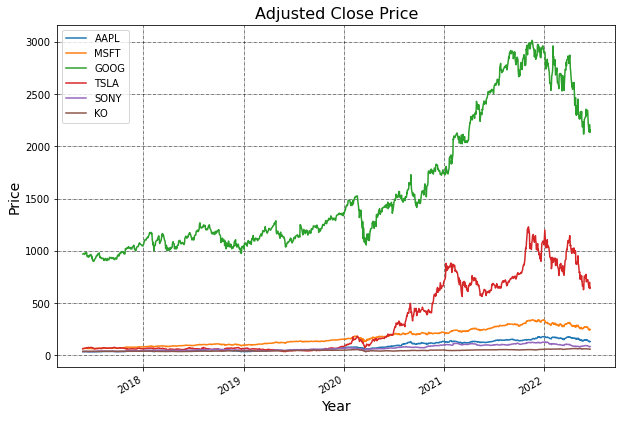

In [8]:
from matplotlib import pyplot as plt

# Plot all the close prices
data.plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Adjusted Close Price", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [9]:
data.corr()

,AAPL,MSFT,GOOG,TSLA,SONY,KO
AAPL,1.000000,0.979105,0.953425,0.963388,0.957874,0.848454
MSFT,0.979105,1.000000,0.963422,0.936257,0.962527,0.860191
GOOG,0.953425,0.963422,1.000000,0.947480,0.943793,0.833825
TSLA,0.963388,0.936257,0.947480,1.000000,0.941670,0.788851
SONY,0.957874,0.962527,0.943793,0.941670,1.000000,0.790592
KO,0.848454,0.860191,0.833825,0.788851,0.790592,1.000000


In [10]:
split_ratio = 0.2
X = data.values # Convert to NumPy array
split = int(len(X) * (1-split_ratio))
train_set = X[: split]
test_set = X[split:]
print(train_set.shape, test_set.shape)

(1020, 6) (256, 6)


In [11]:
def supvervisedSeries(data, n, h):
  x, y = list (), list ()
  for i in range (len(data)-n-h+1):
    x.append(data[i:(i+n)])
    y.append(data[i+h+n-1])
  return np.array(x), np.array(y)
h = 1
n = 4
trainX, trainY = supvervisedSeries(train_set, n, h)
testX, testY = supvervisedSeries(test_set, n, h)
print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY: ", testY.shape)

trainX:  (1016, 4, 6)
trainY:  (1016, 6)
testX:  (252, 4, 6)
testY:  (252, 6)


In [12]:
testY = np.reshape(testY[:, 0], (testY [:, 0].shape[0], 1))
trainY = np.reshape(trainY[:, 0], (trainY[:, 0].shape[0], 1))
print('trainY: ', trainY.shape)
print('testY:', testY.shape)

trainY:  (1016, 1)
testY: (252, 1)


In [13]:
# Data Scaling
scalers = {}
for i in range (trainX.shape[2]):
  scalers[i] = MinMaxScaler()
  trainX[:, :, i] = scalers[i].fit_transform(trainX[:, :, i])
for i in range(testX.shape[2]):
  testX[:, :, i] = scalers[i].transform(testX[:, :, i])
# The target values are 2D arrays, which is easy to scale
scalerY = MinMaxScaler()
trainY = scalerY.fit_transform(trainY)
testY = scalerY.transform(testY)

In [14]:
# Feed Forward Neural Network
# 100 neurons in each layer
# Flatten input (to support multivariate input)
n_input = trainX.shape[1] * trainX.shape[2]
trainX = trainX.reshape((trainX.shape[0], n_input))
n_input = testX.shape[1] * testX.shape[2]
testX = testX.reshape((testX.shape[0], n_input))
# Create multilayered FFNN model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=trainX.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# Fit model
history = model.fit(trainX, trainY, epochs =60, verbose =1)
# Predict the test set
predictions = model.predict(testX)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2500      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 22,801
Trainable params: 22,801
Non-traina

In [15]:
# Descale
predictions = scalerY.inverse_transform(predictions)
testY = scalerY.inverse_transform(testY)
# Mean absolute error
mae = mean_absolute_error(testY, predictions)



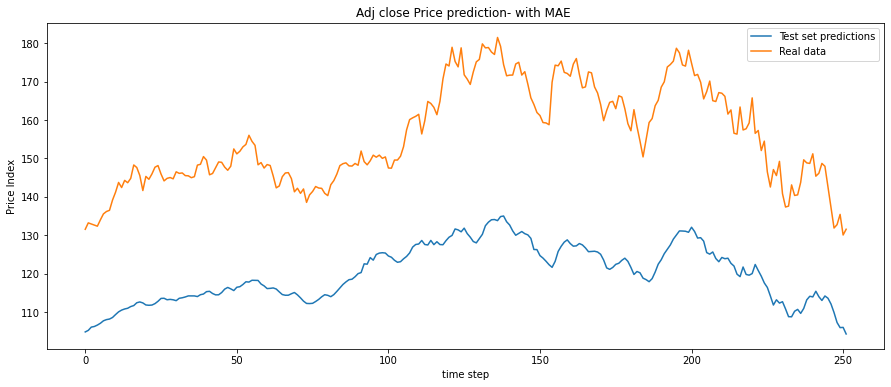

In [16]:
# Plot prediction vs actual values:
plt.figure(figsize=(15,6))
plt.plot(predictions, label="Test set predictions" )
plt.plot(testY, label="Real data")
plt.legend()
plt.ylabel('Price Index')
plt.xlabel('time step' )
plt.title ("Adj close Price prediction- with MAE ")
plt.show()

In [17]:
import streamlit as st

In [ ]:
st.set_page_config(page_icon="📈", page_title="Stock Dashboard")
